# Car price prediction - Feature Engineering + Modeling
_Cong Tung Nguyen (October 2022)_ 
<br>
----

### 1. Importing the libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import pickle
import scipy.stats as stats
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error,r2_score
from bayes_opt import BayesianOptimization
import xgboost as xgb
from xgboost import XGBRegressor
import tensorflow as tf

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### 2. Importing the dataset

In [ ]:
cars_df_cleaned = pd.read_pickle('./dataset/cars_df_cleaned.pkl')

In [ ]:
cars_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 0 to 488
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price (HUF)       487 non-null    int64  
 1   Brand             487 non-null    object 
 2   Year              487 non-null    object 
 3   Condition         487 non-null    object 
 4   Design            487 non-null    object 
 5   Kilometers        487 non-null    int64  
 6   Persons           473 non-null    object 
 7   Doors             477 non-null    object 
 8   Own_weight (kg)   458 non-null    float64
 9   Full_weight (kg)  456 non-null    float64
 10  Trunk (liter)     421 non-null    float64
 11  Fuel              483 non-null    object 
 12  Cylinder (cm3)    477 non-null    float64
 13  Layout            436 non-null    object 
 14  Wheel_drive       470 non-null    object 
 15  Gearbox           470 non-null    object 
 16  Document          487 non-null    object 
 1

### 3. Data preparation

### Reducing the dataset

#### a) Exclude imbalance columns

We are going to exclude the imbalance columns, because our dataset is very small.
Having just a few rows of data for one class degrades model quality. Also high cardinality columns such as colour will be excluded.

Imbalance columns: ['Persons','Doors,'Layout','Document','Roadworthiness','Colour']

Instead of the Year column, we are going to use the calculated Age column

In [ ]:
exclude_cols = ['Year','Persons','Doors','Layout','Document','Roadworthiness','Colour']
needed_cols = [cols for cols in list(cars_df_cleaned.columns) if cols not in exclude_cols]

# Choose relevant columns
cars_df_cleaned = cars_df_cleaned[needed_cols]

#### b) Generalization

The following columns could be generalized: 
- ['Fuel'] ➡ ('Benzin','Dízel','Hibrid/Elektromos') ➡ 'Benzin/Gáz' into 'Benzin' group
- ['Gearbox'] ➡ ('Automata','Szekvenciális','Manuális') ➡ 'Tiptronic' into 'Automata' group
- ['AirCon_Type] ➡ ('Automata','Manuális','Digitális') ➡ 'Hőszivattyús klíma' observation will be put into one of these groups

In [ ]:
# Fuel
cars_df_cleaned['Fuel_generalized'] = cars_df_cleaned['Fuel'].apply(lambda x: 'Benzin' if 'benzin' in str(x).lower() else x)
cars_df_cleaned['Fuel_generalized'] = cars_df_cleaned.apply(lambda x: 'Hibrid_Elektromos' if 'hibrid' in str(x.Fuel).lower() else x.Fuel_generalized, axis = 1)
cars_df_cleaned['Fuel_generalized'] = cars_df_cleaned.apply(lambda x: 'Hibrid_Elektromos' if 'elektromos' in str(x.Fuel).lower() else x.Fuel_generalized, axis = 1)
cars_df_cleaned['Fuel_generalized'] = cars_df_cleaned.apply(lambda x: 'Manuális' if 'manuális' in str(x.Fuel).lower() else x.Fuel_generalized, axis = 1)

# Gearbox
cars_df_cleaned['Gearbox_generalized'] = cars_df_cleaned['Gearbox'].apply(lambda x: 'Automata' if 'automata' in str(x).lower() else x)
cars_df_cleaned['Gearbox_generalized'] = cars_df_cleaned.apply(lambda x: 'Automata' if 'tiptronic' in str(x.Gearbox).lower() else x.Gearbox_generalized, axis=1)
cars_df_cleaned['Gearbox_generalized'] = cars_df_cleaned.apply(lambda x: 'Szekvenciális' if 'szekvenciális' in str(x.Gearbox).lower() else x.Gearbox_generalized, axis = 1)
cars_df_cleaned['Gearbox_generalized'] = cars_df_cleaned.apply(lambda x: 'Manuális' if 'manuális' in str(x.Gearbox).lower() else x.Gearbox_generalized, axis = 1)

# Aircondition
cars_df_cleaned['AirCon_Type_generalized'] = cars_df_cleaned['AirCon_Type'].apply(lambda x: 'Digitális' if 'digitális' in str(x).lower() else x)
cars_df_cleaned['AirCon_Type_generalized'] = cars_df_cleaned.apply(lambda x: 'Automata' if 'automata' in str(x.AirCon_Type).lower() else x.AirCon_Type_generalized, axis = 1)
cars_df_cleaned['AirCon_Type_generalized'] = cars_df_cleaned.apply(lambda x: 'Manuális' if 'manuális' in str(x.AirCon_Type).lower() else x.AirCon_Type_generalized, axis = 1)
cars_df_cleaned['AirCon_Type_generalized'] = cars_df_cleaned.apply(lambda x: 'Automata' if 'hőszivattyús klíma' in str(x.AirCon_Type).lower() else x.AirCon_Type_generalized, axis = 1)

In [ ]:
df_model = cars_df_cleaned[['Price (HUF)',
                           'Brand',
                           'Condition',
                           'Design',
                           'Kilometers',
                           'Own_weight (kg)',
                           'Full_weight (kg)',
                           'Trunk (liter)',
                           'Cylinder (cm3)',
                           'Wheel_drive',
                           'Power (kW)',
                           'HorsePower (hp)',
                           'Age',
                           'Fuel_generalized',
                           'Gearbox_generalized',
                           'AirCon_Type_generalized']]

### Handling missing values

In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 0 to 488
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Price (HUF)              487 non-null    int64  
 1   Brand                    487 non-null    object 
 2   Condition                487 non-null    object 
 3   Design                   487 non-null    object 
 4   Kilometers               487 non-null    int64  
 5   Own_weight (kg)          458 non-null    float64
 6   Full_weight (kg)         456 non-null    float64
 7   Trunk (liter)            421 non-null    float64
 8   Cylinder (cm3)           477 non-null    float64
 9   Wheel_drive              470 non-null    object 
 10  Power (kW)               482 non-null    float64
 11  HorsePower (hp)          482 non-null    float64
 12  Age                      487 non-null    int64  
 13  Fuel_generalized         483 non-null    object 
 14  Gearbox_generalized      4

There are missing values in the following columns:

Numerical cols: 
* ['Own_weight (kg)','Full_weight (kg)','Trunk (liter)','Cylinder (cm3)','Power (kW)','HorsePower (hp)']

Categorical cols: 
* ['Wheel_drive','Fuel_generalized','Gearbox_generalized','AirCon_Type_generalized']

We are going to use a regression model (random forest regression) to predict the missing numerical values.

For the categorical ones, we are going to replace the null values with the mode.

### a) Categorical variables

In [ ]:
# Wheel_drive
most_common_val_wheel_drive = df_model['Wheel_drive'].value_counts().sort_values(ascending = False).index[0]
df_model['Wheel_drive'].fillna(value = most_common_val_wheel_drive, inplace=True)

# Fuel_generalized
most_common_val_fuel_generalized = df_model['Fuel_generalized'].value_counts().sort_values(ascending = False).index[0]
df_model['Fuel_generalized'].fillna(value = most_common_val_fuel_generalized, inplace=True)

# Gearbox_generalized
most_common_val_gearbox_generalized = df_model['Gearbox_generalized'].value_counts().sort_values(ascending = False).index[0]
df_model['Gearbox_generalized'].fillna(value = most_common_val_gearbox_generalized, inplace=True)

# AirCon_Type_generalized
most_common_val_aircon_generalized = df_model['AirCon_Type_generalized'].value_counts().sort_values(ascending = False).index[0]
df_model['AirCon_Type_generalized'].fillna(value = most_common_val_aircon_generalized, inplace=True)

C:\Users\Asus\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


### b) Numerical variables

The dependent variables are going to be the ones, where the missing values are existed. We are going to use the whole dataset, which contains non-missing values, as our training dataset. With the final model we are going to predict the missing values.

In [ ]:
# One hot encoding, drop first = True, to avoid dummy variable trap
df_model_dummies = pd.get_dummies(df_model, drop_first=True)

In [ ]:
df_model_dummies.head()

,Price (HUF),Kilometers,Own_weight (kg),Full_weight (kg),Trunk (liter),Cylinder (cm3),Power (kW),HorsePower (hp),Age,Brand_ALFA,Brand_AUDI,Brand_BMW,Brand_CHEVROLET,Brand_CHRYSLER,Brand_CITROEN,Brand_DACIA,Brand_DAEWOO,Brand_FIAT,Brand_FORD,Brand_HONDA,Brand_HYUNDAI,Brand_INFINITI,Brand_JAGUAR,Brand_JEEP,Brand_KIA,Brand_LADA,Brand_LANCIA,Brand_LAND,Brand_LEXUS,Brand_LINCOLN,Brand_MAZDA,Brand_MERCEDES-BENZ,Brand_MG,Brand_MICROCAR,Brand_MINI,Brand_MITSUBISHI,Brand_NISSAN,Brand_OPEL,Brand_PEUGEOT,Brand_PORSCHE,Brand_RENAULT,Brand_SEAT,Brand_SKODA,Brand_SMART,Brand_SSANGYONG,Brand_SUZUKI,Brand_TOYOTA,Brand_TRABANT,Brand_UAZ,Brand_VOLKSWAGEN,Brand_VOLVO,Condition_Megkímélt,Condition_Normál,Condition_Sérülésmentes,Condition_Újszerű,Design_Cabrio,Design_Coupe,Design_Egyterű,Design_Ferdehátú,Design_Kisbusz,Design_Kombi,Design_Lépcsőshátú,Design_Mopedautó,Design_Sedan,Design_Terepjáró,Design_Városi terepjáró (crossover),Wheel_drive_Hátsó kerék,Wheel_drive_Kapcsolható összkerék,Wheel_drive_Összkerék,Fuel_generalized_Dízel,Fuel_generalized_Hibrid_Elektromos,Gearbox_generalized_Manuális,Gearbox_generalized_Szekvenciális,AirCon_Type_generalized_Digitális,AirCon_Type_generalized_Manuális
0,499999,290000,1054.0,1539.0,248.0,1198.0,40.0,54.0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,499999,240000,1045.0,1515.0,284.0,1299.0,51.0,69.0,19,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,500000,222150,1170.0,1710.0,355.0,1498.0,72.0,98.0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,420000,183000,1135.0,1645.0,340.0,1390.0,55.0,75.0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,529000,165000,1000.0,1490.0,220.0,1399.0,61.0,83.0,18,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


#### Function for imputing missing values with ML

In [ ]:
def ml_imputer(df, x_cols, y_col):
    '''
    Parameters:
    df --> df_model with dummy variables (one-hot encoding)
    x_cols --> list of independent vars
    y_col --> name of the dependant variable
    '''

    df_train = df.loc[~df[y_col].isnull()]
    df_test = df.loc[df[y_col].isnull()] 
    
    # Training - Test set
    X_train = np.array(df_train[x_cols])
    y_train = np.array(df_train[y_col])
    X_test = np.array(df_test[x_cols])
    y_test = np.array(df_test[y_col])
    
    # Grid search for hyperparameter tuning
    param_grid = {
        'min_samples_leaf': [3, 4, 5],
        'min_samples_split': [8, 10, 12],
        'n_estimators': np.arange(100,500,50)
    }
    
    # Create Random Forest Model
    rf = RandomForestRegressor()

    # Grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                               cv = 5, n_jobs = -1, verbose = 2)
    
    grid_search.fit(X_train, y_train)
    
    # Predict the missing values
    y_pred = grid_search.predict(X_test)
    
    return y_pred

In [ ]:
x_cols = [x for x in df_model_dummies.columns if x not in ['Own_weight (kg)','Full_weight (kg)','Trunk (liter)','Cylinder (cm3)','Power (kW)','HorsePower (hp)']]

#### Own_weight (kg)

In [ ]:
y_pred = ml_imputer(df=df_model_dummies, x_cols=x_cols, y_col='Own_weight (kg)')

# Replace the missing values with the predicted values
df_model.loc[df_model['Own_weight (kg)'].isnull(),'Own_weight (kg)'] = y_pred

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\Asus\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#### Full_weight (kg)

In [ ]:
y_pred = ml_imputer(df=df_model_dummies, x_cols=x_cols, y_col='Full_weight (kg)')

# Replace the missing values with the predicted values
df_model.loc[df_model['Full_weight (kg)'].isnull(),'Full_weight (kg)'] = y_pred

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\Asus\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#### Trunk variable

In [ ]:
y_pred = ml_imputer(df=df_model_dummies, x_cols=x_cols, y_col='Trunk (liter)')

# Replace the missing values with the predicted values
df_model.loc[df_model['Trunk (liter)'].isnull(),'Trunk (liter)'] = y_pred

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\Asus\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#### Cylinder variable

In [ ]:
y_pred = ml_imputer(df=df_model_dummies, x_cols=x_cols, y_col='Cylinder (cm3)')

# Replace the missing values with the predicted values
df_model.loc[df_model['Cylinder (cm3)'].isnull(),'Cylinder (cm3)'] = y_pred

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\Asus\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#### Power (kW) variable

In [ ]:
y_pred = ml_imputer(df=df_model_dummies, x_cols=x_cols, y_col='Power (kW)')

# Replace the missing values with the predicted values
df_model.loc[df_model['Power (kW)'].isnull(),'Power (kW)'] = y_pred

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\Asus\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#### HorsePower (hp) variable

In [ ]:
y_pred = ml_imputer(df=df_model_dummies, x_cols=x_cols, y_col='HorsePower (hp)')

# Replace the missing values with the predicted values
df_model.loc[df_model['HorsePower (hp)'].isnull(),'HorsePower (hp)'] = y_pred

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\Asus\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


### Handling outliers

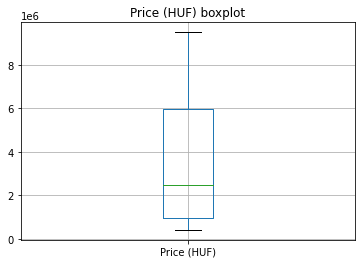

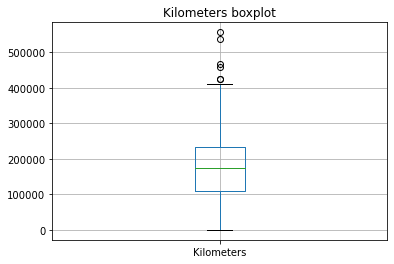

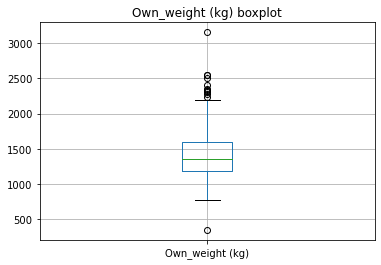

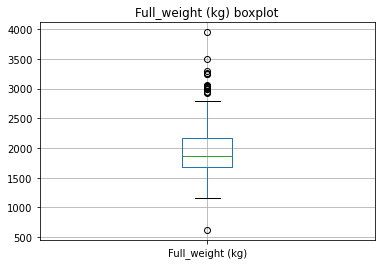

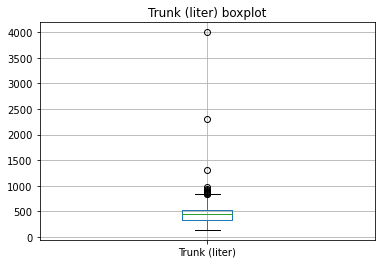

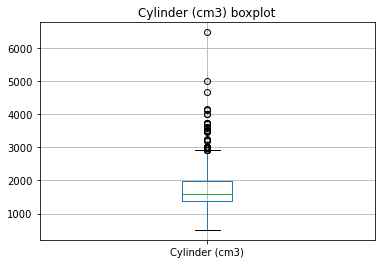

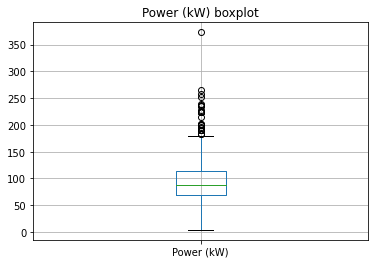

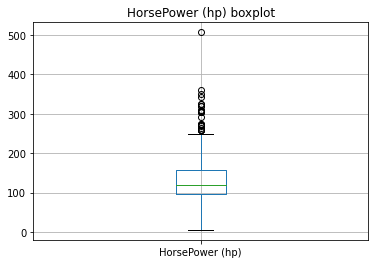

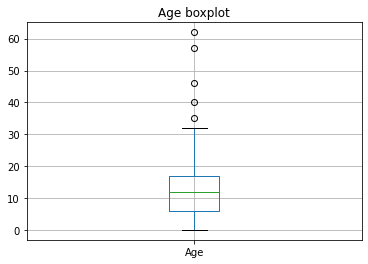

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = df_model.select_dtypes(include=numerics).columns

for col in numeric_cols:
    df_model.boxplot(column=[col])
    plt.title(col + ' boxplot')
    plt.show()

I will handle the outliers with binning technique.

In the Age column there are a couple outlier values, I will just simply drop them. (For instance age is greater than 60)

In [ ]:
# Drop observation in Age
Q1,Q3 = np.percentile(df_model['Age'], [25,75])
IQR = Q3 - Q1
ul = Q3+1.5*IQR
#ll = Q1-1.5*IQR 

# New car should not be dropped so I will just filter based on the upper limit
drop_indexes = df_model.loc[(df_model['Age']>ul)].index

df_model.drop(index=drop_indexes, inplace = True)

C:\Users\Asus\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
def handle_outliers_binning(df, outlier_column, new_column_name):
    '''
    'df' parameter is the dataframe which contains outlier values.
    'outlier_column' is the name of the variable which contains outlier values.
    'new_column_name is the new name of the smoothened column
    '''
    
    # Calculate IQR range, upper limit and lower limit
    Q1,Q3 = np.percentile(df[outlier_column], [25,75])
    IQR = Q3 - Q1
    ul = Q3+1.5*IQR
    ll = Q1-1.5*IQR 
    
    # Flag the outlier observations
    df['outlier_flag'] = df[outlier_column].apply(lambda x: 1 if (x>ul) or (x<ll) else 0)
    
    # Create binning groups
    df['binning_group'] = pd.qcut(df[outlier_column], 10, labels=False)
    
    # Create a dictionary, which key is the group and value is the median value  
    group_averages = df.groupby(by=['binning_group'])[outlier_column].median().to_dict()
    
    # If (outlier flag==1) then [specific value in the dict] else [do not modify value]
    df[new_column_name] = df[[outlier_column, 'outlier_flag','binning_group']]\
                          .apply(lambda x: x[0] if x[1]==0 else group_averages[x[2]], axis = 1)
    
    # Drop flags and group columns
    df.drop(columns = ['outlier_flag','binning_group'], inplace=True)
    
    return df

In [ ]:
# Kilometers
df_model = handle_outliers_binning(df_model, outlier_column='Kilometers', new_column_name='Kilometers_Handled_Outlier')

<ipython-input-21-ca767d78d755>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outlier_flag'] = df[outlier_column].apply(lambda x: 1 if (x>ul) or (x<ll) else 0)
<ipython-input-21-ca767d78d755>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binning_group'] = pd.qcut(df[outlier_column], 10, labels=False)
<ipython-input-21-ca767d78d755>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [ ]:
# Own_weight (kg)
df_model = handle_outliers_binning(df_model, outlier_column='Own_weight (kg)', new_column_name='Own_weight (kg)_Handled_Outlier')

<ipython-input-21-ca767d78d755>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outlier_flag'] = df[outlier_column].apply(lambda x: 1 if (x>ul) or (x<ll) else 0)
<ipython-input-21-ca767d78d755>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binning_group'] = pd.qcut(df[outlier_column], 10, labels=False)
<ipython-input-21-ca767d78d755>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [ ]:
# Full_weight (kg)
df_model = handle_outliers_binning(df_model, outlier_column='Full_weight (kg)', new_column_name='Full_weight (kg)_Handled_Outlier')

<ipython-input-21-ca767d78d755>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outlier_flag'] = df[outlier_column].apply(lambda x: 1 if (x>ul) or (x<ll) else 0)
<ipython-input-21-ca767d78d755>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binning_group'] = pd.qcut(df[outlier_column], 10, labels=False)
<ipython-input-21-ca767d78d755>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [ ]:
# Trunk (liter)
df_model = handle_outliers_binning(df_model, outlier_column='Trunk (liter)', new_column_name='Trunk (liter)_Handled_Outlier')

<ipython-input-21-ca767d78d755>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outlier_flag'] = df[outlier_column].apply(lambda x: 1 if (x>ul) or (x<ll) else 0)
<ipython-input-21-ca767d78d755>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binning_group'] = pd.qcut(df[outlier_column], 10, labels=False)
<ipython-input-21-ca767d78d755>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [ ]:
# Cylinder (cm3)
df_model = handle_outliers_binning(df_model, outlier_column='Cylinder (cm3)', new_column_name='Cylinder (cm3)_Handled_Outlier')

<ipython-input-21-ca767d78d755>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outlier_flag'] = df[outlier_column].apply(lambda x: 1 if (x>ul) or (x<ll) else 0)
<ipython-input-21-ca767d78d755>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binning_group'] = pd.qcut(df[outlier_column], 10, labels=False)
<ipython-input-21-ca767d78d755>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [ ]:
# Power (kW)
df_model = handle_outliers_binning(df_model, outlier_column='Power (kW)', new_column_name='Power (kW)_Handled_Outlier')

<ipython-input-21-ca767d78d755>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outlier_flag'] = df[outlier_column].apply(lambda x: 1 if (x>ul) or (x<ll) else 0)
<ipython-input-21-ca767d78d755>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binning_group'] = pd.qcut(df[outlier_column], 10, labels=False)
<ipython-input-21-ca767d78d755>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [ ]:
# HorsePower (hp)
df_model = handle_outliers_binning(df_model, outlier_column='HorsePower (hp)', new_column_name='HorsePower (hp)_Handled_Outlier')

<ipython-input-21-ca767d78d755>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['outlier_flag'] = df[outlier_column].apply(lambda x: 1 if (x>ul) or (x<ll) else 0)
<ipython-input-21-ca767d78d755>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binning_group'] = pd.qcut(df[outlier_column], 10, labels=False)
<ipython-input-21-ca767d78d755>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

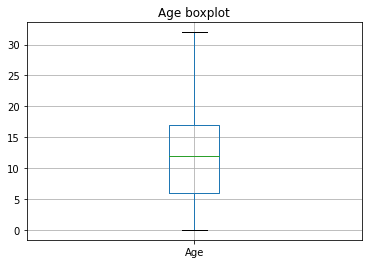

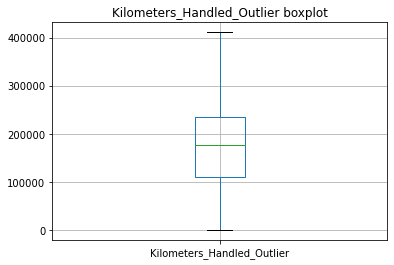

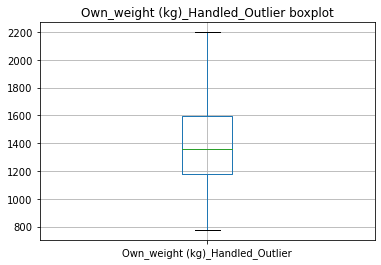

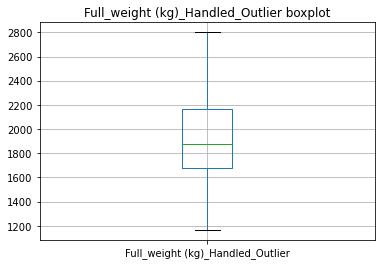

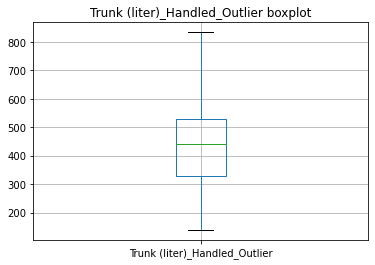

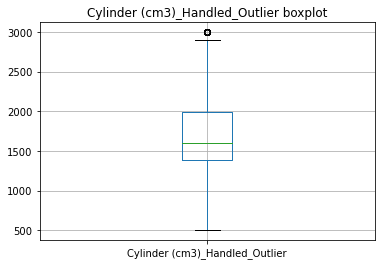

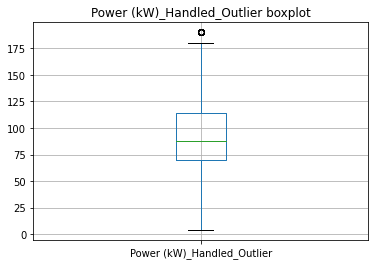

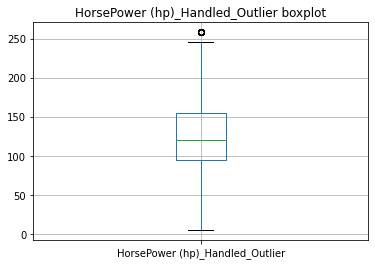

In [ ]:
# Check outlier again
numeric_cols = ['Age'] + [col for col in df_model.columns if 'Handled_Outlier' in col]

for col in numeric_cols:
    df_model.boxplot(column=[col])
    plt.title(col + ' boxplot')
    plt.show()

### Creating calculated columns

In [ ]:
# Calculated column: Average kilometers/year

#df_model['Avg_km_per_year'] = df_model['Kilometers']/df_model['Age'] cannot divide by 0
df_model['Avg_km_per_year'] = df_model[['Kilometers','Age']].apply(lambda x: x[0] if x[1]==0 else x[0]/x[1],axis=1)

### 4. Final modeling

#### a) Feature selection

I will try out a couple of **filtering** methods such as low variance filter or high correlation filter, and also I will build a Random Forest Regressor (**embedded method**) on the training data and check the feature importances. Due to the fact that my dataset contains several high cardinality categorical variables, I do not think that the feature importance will be useful.

Wrapper methods such as Sequential Backward Selection and Sequential Foreward Selection will not be used, due to the fact that computationally it is very expensive.

#### Filter methods

In [ ]:
# Low variance filter
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = df_model.select_dtypes(include=numerics).columns.tolist()[1:]

X = df_model[numeric_cols]

selector = VarianceThreshold()
selector.fit(X)

selector.variances_

array([5.56974000e+05, 2.80000000e+03, 3.33000000e+03, 3.86100000e+03,
       5.96100000e+03, 3.69000000e+02, 5.02000000e+02, 3.20000000e+01,
       4.10999000e+05, 1.42300000e+03, 1.63500000e+03, 6.94758663e+02,
       2.48900000e+03, 1.86000000e+02, 2.53000000e+02, 7.61550833e+04])

There are no columns where the variance is low.

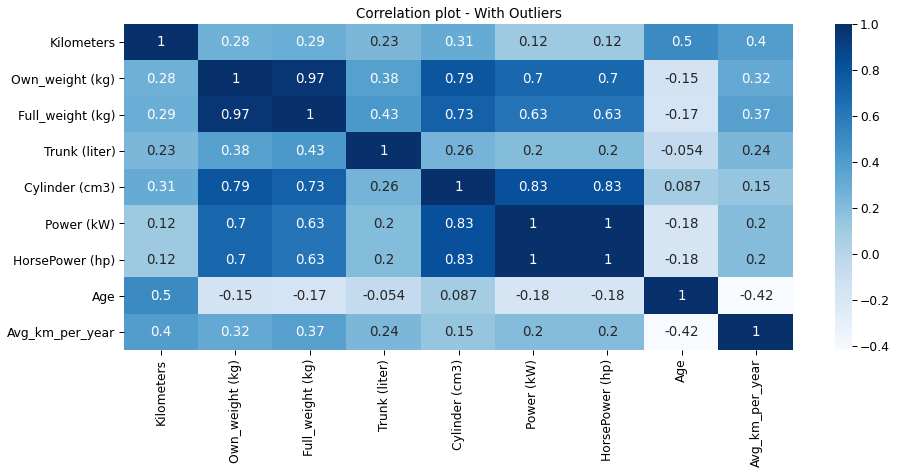

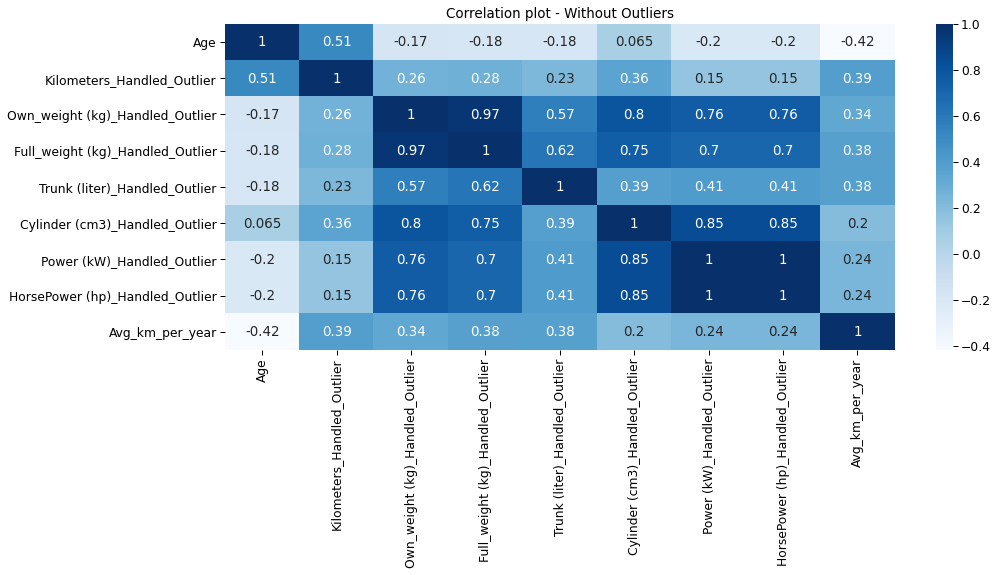

In [ ]:
# High correlation filter - Numerical

cols_with_outlier = ['Kilometers',
                     'Own_weight (kg)',
                     'Full_weight (kg)',
                     'Trunk (liter)',
                     'Cylinder (cm3)',
                     'Power (kW)',
                     'HorsePower (hp)',
                     'Age',
                     'Avg_km_per_year']

cols_without_outlier = ['Age',
                         'Kilometers_Handled_Outlier',
                         'Own_weight (kg)_Handled_Outlier',
                         'Full_weight (kg)_Handled_Outlier',
                         'Trunk (liter)_Handled_Outlier',
                         'Cylinder (cm3)_Handled_Outlier',
                         'Power (kW)_Handled_Outlier',
                         'HorsePower (hp)_Handled_Outlier',
                         'Avg_km_per_year']

corr_mx = df_model[cols_with_outlier].corr()
plt.figure(figsize=(15,6))
sns.set_context('paper',font_scale=1.4)
sns.heatmap(corr_mx, annot=True, cmap='Blues')
plt.title('Correlation plot - With Outliers')
plt.show()

corr_mx = df_model[cols_without_outlier].corr()
plt.figure(figsize=(15,6))
sns.set_context('paper',font_scale=1.4)
sns.heatmap(corr_mx, annot=True, cmap='Blues')
plt.title('Correlation plot - Without Outliers')
plt.show()

Own weight and Full weight has a high correlation with most of the variables, I will remove them. Cylinder, Power and HorsePower has a high correlation with each other, I will just keep one of them.

In [ ]:
# Dropping columns
df_model.drop(columns=['Own_weight (kg)','Full_weight (kg)','Power (kW)','HorsePower (hp)'\
                       ,'Own_weight (kg)_Handled_Outlier','Full_weight (kg)_Handled_Outlier'\
                       ,'Power (kW)_Handled_Outlier','HorsePower (hp)_Handled_Outlier'], inplace=True)

For the categorical variables, I will calculate the Cramer association indicator.

√(X2/ (N * min(C-1, R-1)))

Here, 

* X2: It is the Chi-square statistic
* N: It represents the total sample size
* R: It is equal to the number of rows
* C: It is equal to the number of columns

In [ ]:
def cramer_association(df, variable_1, variable_2):
    
    # Contingency table
    contin_table = pd.crosstab(df[variable_1],
                               df[variable_2], 
                               margins = False) 
    
    # Chi-square statistics
    chi2, p, dof, expected = stats.chi2_contingency(np.array(contin_table))
    N = df_model.shape[0]
    min_dim = min(contin_table.shape)-1

    # Cramer's V
    cramer = np.sqrt((chi2) / (N* min_dim))
    
    return cramer

categorical_variables = ['Brand',
                         'Condition',
                         'Design',
                         'Wheel_drive',
                         'Fuel_generalized',
                         'Gearbox_generalized',
                         'AirCon_Type_generalized']

rows= []

for var1 in categorical_variables:
    
    col = []
    
    for var2 in categorical_variables:
        
        cramers =cramer_association(df_model, var1, var2) # Cramer's V test
        col.append(round(cramers,3)) # Keeping of the rounded value of the Cramer's V 
        
    rows.append(col)

    
results = np.array(rows)
df_cramer = pd.DataFrame(results, columns = categorical_variables, index =categorical_variables)
df_cramer

,Brand,Condition,Design,Wheel_drive,Fuel_generalized,Gearbox_generalized,AirCon_Type_generalized
Brand,1.000,0.310,0.575,0.637,0.412,0.464,0.393
Condition,0.310,1.000,0.154,0.099,0.112,0.152,0.110
Design,0.575,0.154,1.000,0.456,0.270,0.287,0.271
Wheel_drive,0.637,0.099,0.456,1.000,0.224,0.368,0.162
Fuel_generalized,0.412,0.112,0.270,0.224,1.000,0.280,0.149
Gearbox_generalized,0.464,0.152,0.287,0.368,0.280,1.000,0.216
AirCon_Type_generalized,0.393,0.110,0.271,0.162,0.149,0.216,1.000


Brand has a moderate correlation with the other variables, and also a high cardinality column, therefore I will drop it.

In [ ]:
df_model.drop(columns=['Brand'], inplace=True)

In [ ]:
# Embedded method

columns_no_outlier = ['Price (HUF)',
 'Condition',
 'Design',
 'Wheel_drive',
 'Age',
 'Fuel_generalized',
 'Gearbox_generalized',
 'AirCon_Type_generalized',
 'Kilometers_Handled_Outlier',
 'Trunk (liter)_Handled_Outlier',
 'Cylinder (cm3)_Handled_Outlier',
 'Avg_km_per_year']


# Dummification
df_feat_imp =  pd.get_dummies(df_model[columns_no_outlier], drop_first=True)
X = np.array(df_feat_imp.iloc[:,1:])
y = np.array(df_feat_imp.iloc[:,0])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)

# Fitting model
clf_rf = RandomForestRegressor()
clf_rf.fit(X_train, y_train)

# Extract feature importance
imp = zip(df_feat_imp.columns[1:], clf_rf.feature_importances_)
df_imp = pd.DataFrame(imp, columns = ['feature', 'importance']).sort_values(axis=0, by='importance', ascending=False).set_index('feature')
df_imp

,importance
feature,
Age,6.835450e-01
Cylinder (cm3)_Handled_Outlier,1.721205e-01
Kilometers_Handled_Outlier,2.586962e-02
Gearbox_generalized_Manuális,2.144688e-02
AirCon_Type_generalized_Manuális,1.908202e-02
Trunk (liter)_Handled_Outlier,1.869455e-02
Avg_km_per_year,1.328952e-02
Design_Városi terepjáró (crossover),6.417607e-03
Wheel_drive_Hátsó kerék,6.201388e-03


As it was expected, Age is a very important variable when it comes to the price of the car. After applying the embedded method, I decided not to drop any additional columns.

Last but not least I will apply the supervised feature selection method. I will calculate correlation coefficient and H indicator.

In [ ]:
# Supervised method
# Columns 
num_cols = ['Age','Kilometers_Handled_Outlier', 'Trunk (liter)_Handled_Outlier','Cylinder (cm3)_Handled_Outlier', 'Avg_km_per_year']
cat_cols = ['Condition', 'Design', 'Wheel_drive','Fuel_generalized','Gearbox_generalized', 'AirCon_Type_generalized']
cols = num_cols + cat_cols

# Log correlation and H indicator in corr list
corr = []

for col in cols:
    if col in num_cols:
        
        # Pearson correlation with numerical columns
        corr.append(np.corrcoef(df_model['Price (HUF)'],df_model[col])[0][1])
        
    if col in cat_cols:
        # Variance analysis
        
        # group standard deviations
        std_groups = df_model.groupby(by=[col])['Price (HUF)'].std().reset_index().set_index(col).rename(columns={'Price (HUF)':'std'})
        
        # group averages
        avg_groups = df_model.groupby(by=[col])['Price (HUF)'].mean().reset_index().set_index(col).rename(columns={'Price (HUF)':'avg'})
        
        # group sample sizes
        n_groups = df_model.groupby(by=[col])['Price (HUF)'].count().reset_index().set_index(col).rename(columns={'Price (HUF)':'n'})
        
        # y average whole dataset
        mean_all = df_model['Price (HUF)'].mean()
        
        # sample size whole dataset
        N = df_model.shape[0]
        
        # construct final table
        final = std_groups.join(avg_groups)
        final = final.join(n_groups)
        
        # Calculate variances
        belso_var = np.sum((final['n']*final['std']**2))/N
        kulso_var = np.sum(final['n']*(final['avg']-mean_all)**2)/N
        teljes_var = df_model['Price (HUF)'].var()
        H2 = kulso_var/teljes_var
        H = np.sqrt(H2)
        
        # Append H into corr
        corr.append(H)
        
pd.DataFrame(corr, columns=['Price (HUF)'], index=[cols]).T

,Age,Kilometers_Handled_Outlier,Trunk (liter)_Handled_Outlier,Cylinder (cm3)_Handled_Outlier,Avg_km_per_year,Condition,Design,Wheel_drive,Fuel_generalized,Gearbox_generalized,AirCon_Type_generalized
Price (HUF),-0.768791,-0.420918,0.308307,0.322682,0.338892,0.404228,0.402771,0.355714,0.323866,0.491047,0.356109


I will keep only the variables where the correlation is at least 0.35.

In [ ]:
#df_model.to_pickle('./dataset/df_model.pkl')
df_model = pd.read_pickle('./dataset/df_model.pkl')

In [ ]:
df_model_feature_selected = df_model.drop(columns=['Trunk (liter)_Handled_Outlier','Cylinder (cm3)_Handled_Outlier','Avg_km_per_year','Fuel_generalized','Trunk (liter)','Cylinder (cm3)','Kilometers'])

#### b) Final modeling

#### One-hot encoding

In [ ]:
df_model_dummy = pd.get_dummies(df_model_feature_selected, drop_first=True)

In [ ]:
df_model_dummy.head()

,Price (HUF),Age,Kilometers_Handled_Outlier,Condition_Megkímélt,Condition_Normál,Condition_Sérülésmentes,Condition_Újszerű,Design_Coupe,Design_Egyterű,Design_Ferdehátú,Design_Kisbusz,Design_Kombi,Design_Lépcsőshátú,Design_Mopedautó,Design_Sedan,Design_Terepjáró,Design_Városi terepjáró (crossover),Wheel_drive_Hátsó kerék,Wheel_drive_Kapcsolható összkerék,Wheel_drive_Összkerék,Gearbox_generalized_Manuális,Gearbox_generalized_Szekvenciális,AirCon_Type_generalized_Digitális,AirCon_Type_generalized_Manuális
0,499999,19,290000.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,499999,19,240000.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,500000,19,222150.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,420000,19,183000.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,529000,18,165000.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0


#### Train-test split

In [ ]:
X = np.array(df_model_dummy.iloc[:,1:])
y = np.array(df_model_dummy.iloc[:,0])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)

#### Feature scaling (for ANN)

We are going to use the min-max scaler in order to scale the data down to [0,1]

In [ ]:
sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [ ]:
# Saving the scaler into a pickle file
pickle.dump(sc, open('./objects/scaler.pkl','wb'))

#### Model building

In [ ]:
# Evaluation function for calculating the performance of each model

def eval_metrics(y_test,y_pred):
    
    mae = mean_absolute_error(y_test,y_pred)
    mape = mean_absolute_percentage_error(y_test,y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test,y_pred)
    
    return mae, mape, mse, rmse, r2

#### a) Linear Regression

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

The linear regression has five key assumptions:

* Linear relationship
* Normality
* No or little multicollinearity
* No auto-correlation
* Homoscedasticity

I will check, whether these assumptions are met in our case.
The function below is from [Jeff Macaluso](https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/) amazing work.

In [ ]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()
    
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')
        
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

#### Linear realtionship:

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


C:\Users\Asus\anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


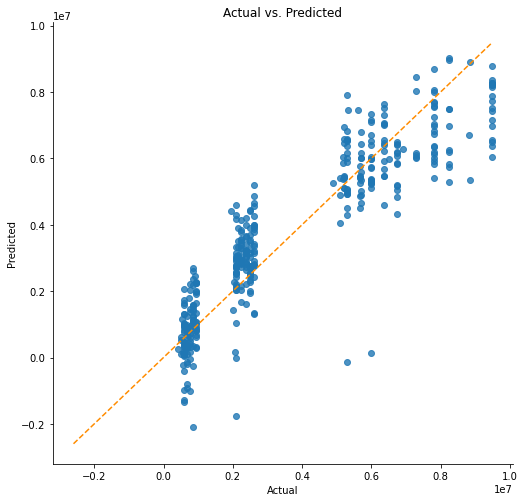

In [ ]:
linear_assumption(lr_model,X_train,y_train)

#### Normality of the Error Terms:

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 7.56288732086351e-08
Residuals are not normally distributed


C:\Users\Asus\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


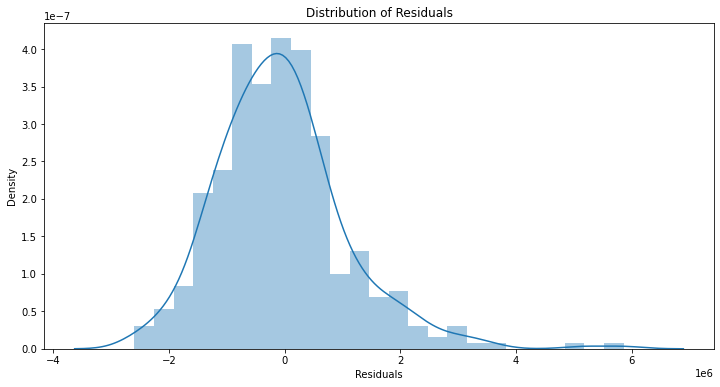


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [ ]:
normal_errors_assumption(lr_model, X_train, y_train)

#### No or little Multicollinearity among Predictors

Assumption 3: Little to no multicollinearity among predictors


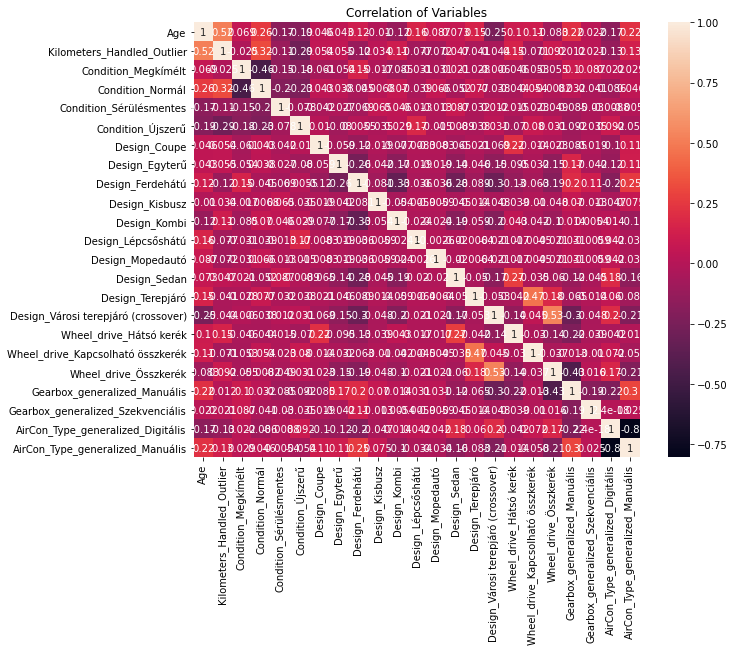

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Age: 8.874256427032634
Kilometers_Handled_Outlier: 8.908475316999409
Condition_Megkímélt: 2.399283175679442
Condition_Normál: 3.1006394729559688
Condition_Sérülésmentes: 1.3484528135083067
Condition_Újszerű: 1.5135681053970667
Design_Coupe: 1.4589301379111632
Design_Egyterű: 2.733361684779907
Design_Ferdehátú: 6.199723370759869
Design_Kisbusz: 1.2448992170032496
Design_Kombi: 3.7723474888901376
Design_Lépcsőshátú: 1.1717698195178337
Design_Mopedautó: 1.087452916819437
Design_Sedan: 3.3844220530050455
Design_Terepjáró: 1.7130192643699138
Design_Városi terepjáró (crossover): 3.765907811728139
Wheel_drive_Hátsó kerék: 1.5037252893818
Wheel_drive_Kapcsolható összkerék: 1.4132758758165922
Wheel_drive_Összkerék: 2.238788191935556
Gearbox_generalized_Manuális: 5.741828581331445
Gearbox_generalized_Szekvenciális: 1

In [ ]:
linear_feature_names = [x for x in df_model_dummy.columns if x != 'Price (HUF)']
multicollinearity_assumption(lr_model, X_train, y_train, linear_feature_names)

Unfortunately, our assumption is not satisfied in that case. However, it was not surprising, because we have a lot of dummy variables, and in that case, multicollinearity cannot be avoided.

#### No Autocorrelation of the Error Terms:

In [ ]:
autocorrelation_assumption(lr_model, X_train, y_train)

Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 2.217456589572334
Little to no autocorrelation 

Assumption satisfied


#### Homoscedasticity:

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


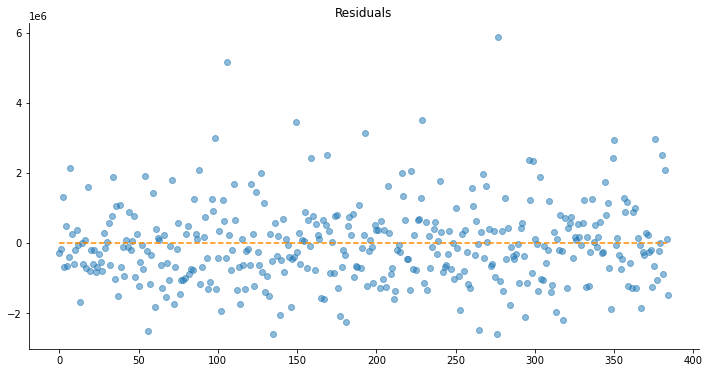

In [ ]:
homoscedasticity_assumption(lr_model, X_train, y_train)

In [ ]:
y_pred_lr = lr_model.predict(X_test)

In [ ]:
lr_mae, lr_mape, lr_mse, lr_rmse, lr_r2 = eval_metrics(y_test, y_pred_lr)

#### Lasso regression

In [ ]:
# Lasso regression

lasso_model = Lasso()

params = {
    'alpha': np.linspace(0.03,5,10)
}

gridsearch = GridSearchCV(
    estimator = lasso_model,
    param_grid = params,
    scoring = 'neg_root_mean_squared_error',
    cv = 5,
    n_jobs = -1
)

grid_results = gridsearch.fit(X_train, y_train)

print(grid_results.best_params_)
print(grid_results.best_score_)

{'alpha': 5.0}
-1275729.1500384298


In [ ]:
y_pred_lasso = gridsearch.predict(X_test)

In [ ]:
lasso_mae, lasso_mape, lasso_mse, lasso_rmse, lasso_r2 = eval_metrics(y_test, y_pred_lasso)

#### XGBoost with Bayesian opt.

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [ ]:
def xgb_evaluate(max_depth, subsample, eta, gamma, min_child_weight, reg_lambda):
    params = {'eval_metric': 'rmse',
              'max_depth': int(max_depth),
              'subsample': max(min(subsample, 1), 0),
              'objective' : 'reg:squarederror',
              'eta': eta,
              'gamma': gamma,
              'min_child_weight': min_child_weight,              
              'reg_lambda': reg_lambda}
    
    # Used around 1000 boosting rounds in the full model
    cv_result = xgb.cv(params, dtrain, num_boost_round=1000, nfold=5)    
    
    # Bayesian optimization only knows how to maximize, not minimize, so return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

In [ ]:
xgb_bo = BayesianOptimization(xgb_evaluate, {'max_depth': (6, 12), 
                                             'gamma': (0.001, 3),
                                             'eta':(0.003, 0.3),
                                             'subsample':(0.6,1),
                                             'min_child_weight':(0,9),
                                             'reg_lambda': (1, 5)})

xgb_bo.maximize(init_points=15, n_iter=35)

|   iter    |  target   |    eta    |   gamma   | max_depth | min_ch... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -1.07e+06 |  0.008844 |  0.5963   |  9.116    |  8.488    |  3.765    |  0.7721   |
|  2        | -1.171e+0 |  0.2748   |  0.06265  |  10.7     |  8.432    |  1.42     |  0.859    |
|  3        | -1.15e+06 |  0.1404   |  1.421    |  11.81    |  8.883    |  3.48     |  0.7085   |
|  4        | -1.107e+0 |  0.0521   |  1.948    |  9.106    |  1.768    |  3.175    |  0.6537   |
|  5        | -1.128e+0 |  0.03312  |  2.529    |  11.24    |  3.263    |  2.928    |  0.8354   |
|  6        | -1.169e+0 |  0.1186   |  1.038    |  7.655    |  6.656    |  1.488    |  0.7985   |
|  7        | -1.185e+0 |  0.1862   |  0.2751   |  6.782    |  4.291    |  2.987    |  0.7463   |
|  8        | -1.135e+0 |  0.07204  |  2.436    |  7.962    |  7.552    |  4.656    |  0.7995   |
|  9        | -1.218

In [ ]:
# Best params
best_params = max(xgb_bo.res, key=lambda x:x['target'])['params']
best_params['max_depth'] = int(best_params['max_depth'])

print(best_params)

{'eta': 0.008843644340169526, 'gamma': 0.5962740785973752, 'max_depth': 9, 'min_child_weight': 8.487801281523918, 'reg_lambda': 3.7653701745275794, 'subsample': 0.7721044864461417}


In [ ]:
final_xgb = XGBRegressor(**best_params)
final_xgb.fit(X_train, y_train)

y_pred_xgb = final_xgb.predict(X_test)

[18:08:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
xgb_mae, xgb_mape, xgb_mse, xgb_rmse, xgb_r2 = eval_metrics(y_test, y_pred_xgb)

#### Neural Network

In [ ]:
# With keras - No hyperparameter opt.

# initializing ann
ann = tf.keras.models.Sequential()

# Adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.1))

# Second hidden layer
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.1))

# Output layer
ann.add(tf.keras.layers.Dense(units=1))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=50)

# adam optimizer (stochastic gradient descent), mean squared error loss function
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
ann.fit(X_train_scaled, y_train, batch_size = 1, epochs = 200, callbacks=[early_stopping])

Epoch 1/200
385/385 [==============================] - 1s 731us/step - loss: 21187572426614.0508
Epoch 2/200
385/385 [==============================] - 0s 763us/step - loss: 22293201078685.8438
Epoch 3/200
385/385 [==============================] - 0s 742us/step - loss: 21848773289676.2695
Epoch 4/200
385/385 [==============================] - 0s 747us/step - loss: 22732621000470.5508
Epoch 5/200
385/385 [==============================] - 0s 762us/step - loss: 20600787573553.0781
Epoch 6/200
385/385 [==============================] - 0s 838us/step - loss: 20363252958032.9102
Epoch 7/200
385/385 [==============================] - 0s 754us/step - loss: 21518087137736.2891
Epoch 8/200
385/385 [==============================] - 0s 742us/step - loss: 18498163591751.6250
Epoch 9/200
385/385 [==============================] - 0s 771us/step - loss: 17167056687422.3418
Epoch 10/200
385/385 [==============================] - 0s 752us/step - loss: 15443108306731.7715
Epoch 11/200
385/385 [=======

385/385 [==============================] - 0s 889us/step - loss: 3013131340444.5181
Epoch 168/200
385/385 [==============================] - 0s 801us/step - loss: 3616476193659.3574
Epoch 169/200
385/385 [==============================] - 0s 799us/step - loss: 3021471066228.7256
Epoch 170/200
385/385 [==============================] - 0s 807us/step - loss: 3336734080514.6528
Epoch 171/200
385/385 [==============================] - 0s 760us/step - loss: 3315209773522.9014
Epoch 172/200
385/385 [==============================] - 0s 741us/step - loss: 2666107619402.2798
Epoch 173/200
385/385 [==============================] - 0s 741us/step - loss: 3342892105897.7822
Epoch 174/200
385/385 [==============================] - 0s 814us/step - loss: 3232983873886.1763
Epoch 175/200
385/385 [==============================] - 0s 880us/step - loss: 3153678480272.5801
Epoch 176/200
385/385 [==============================] - 0s 804us/step - loss: 3611182941772.9326
Epoch 177/200
385/385 [===========

In [ ]:
y_pred_ann_keras = ann.predict(X_test_scaled)

In [ ]:
ann_keras_mae, ann_keras_mape, ann_keras_mse, ann_keras_rmse, ann_keras_r2 = eval_metrics(y_test, y_pred_ann_keras)

In [ ]:
# With sickit learn - RandomSearch

ann_2 = MLPRegressor(hidden_layer_sizes=(4))

params = {
    'activation': ['relu'],
    'hidden_layer_sizes' :[(2,), (3,), (4,), (5,)],
    'solver': ['lbfgs', 'adam'],
    'max_iter': [50, 100, 500, 1000, 2000, 5000, 10000],
    'alpha': [0.0001, 0.001, 0.01],
}

randomsearch_nn = RandomizedSearchCV(
    estimator = ann_2,
    param_distributions = params,
    n_iter = 100,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1
)

random_results_nn = randomsearch_nn.fit(X_train_scaled, y_train.ravel())
print(random_results_nn.best_params_)
print(random_results_nn.best_score_)

{'solver': 'lbfgs', 'max_iter': 10000, 'hidden_layer_sizes': (3,), 'alpha': 0.001, 'activation': 'relu'}
-1073714.914373538


In [ ]:
y_pred_mlpreg = randomsearch_nn.predict(X_test_scaled)

In [ ]:
ann2_keras_mae, ann2_keras_mape, ann2_keras_mse, ann2_keras_rmse, ann2_keras_r2 = eval_metrics(y_test, y_pred_mlpreg)

#### Evaluation

In [ ]:
df_eval = pd.DataFrame({'Model':['Multiple Linear Regression','Lasso Regression','XGBoost','ANN Keras','MLP sklearn'],
                        'MAE':[lr_mae, lasso_mae, xgb_mae, ann_keras_mae, ann2_keras_mae],
                        'MAPE':[lr_mape, lasso_mape, xgb_mape, ann_keras_mape, ann2_keras_mape],
                        'MSE':[lr_mse, lasso_mse, xgb_mse, ann_keras_mse, ann2_keras_mse],
                        'RMSE':[lr_rmse, lasso_rmse, xgb_rmse, ann_keras_rmse, ann2_keras_rmse],
                        'r2':[lr_r2, lasso_r2, xgb_r2, ann_keras_r2, ann2_keras_r2]})

df_eval

,Model,MAE,MAPE,MSE,RMSE,r2
0,Multiple Linear Regression,1.013447e+06,0.397089,2.385196e+12,1.544408e+06,0.708285
1,Lasso Regression,1.013485e+06,0.397111,2.385063e+12,1.544365e+06,0.708301
2,XGBoost,9.961087e+05,0.290294,2.401460e+12,1.549665e+06,0.706296
3,ANN Keras,1.574914e+06,0.570300,4.385372e+12,2.094128e+06,0.463659
4,MLP sklearn,1.043145e+06,0.378700,2.530872e+12,1.590872e+06,0.690469


Seems like Linear Regression, Lasso Regression and XGBoost has the best performance overall.